In [1]:
# =========================
# 1. Import Dependencies
# =========================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor

In [2]:
# ======================================
# 2. Load Training and Test Datasets
# ======================================

train_df = pd.read_csv("../data/training_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

print("Training set size:", len(train_df))
print("Test set size:", len(test_df))

train_df.head()

Training set size: 232
Test set size: 58


,Molecule CAS,CanonicalSMILES,MorganFingerprint,PrimaryWavelength,SecondaryWavelength1,SecondaryWavelength2
0,100-21-0,O=C(O)c1ccc(C(=O)O)cc1,0000000000000000000000000000000000000000000000...,240.0,NaN,NaN
1,100-42-5,C=Cc1ccccc1,0000000000000000000000000000000000000000000000...,248.0,NaN,NaN
2,100-47-0,N#Cc1ccccc1,0000000000000000000000000000000000100000000000...,222.0,277.0,NaN
3,100-52-7,O=Cc1ccccc1,0000000000000000000000000000000000000001000000...,242.0,NaN,NaN
4,100-66-3,COc1ccccc1,0000000000000000000000000000000001000000000000...,220.0,271.0,NaN


In [3]:
# ================================================================
# 3. Convert Morgan Fingerprint (Bitstring) to Numeric Array
# ================================================================
def bitstring_to_array(bitstring):
    return np.array([int(bit) for bit in bitstring])


# Convert train/test fingerprints
X_train = np.vstack(train_df["MorganFingerprint"].apply(bitstring_to_array).values)
X_test = np.vstack(test_df["MorganFingerprint"].apply(bitstring_to_array).values)

# Add missing peak flags as features
for df in [train_df, test_df]:
    df["Has_Secondary1"] = df["SecondaryWavelength1"].notna().astype(int)
    df["Has_Secondary2"] = df["SecondaryWavelength2"].notna().astype(int)

# Combine fingerprint with secondary peak flags
X_train = np.hstack([X_train, train_df[["Has_Secondary1", "Has_Secondary2"]].values])
X_test = np.hstack([X_test, test_df[["Has_Secondary1", "Has_Secondary2"]].values])

# Set target to PRIMARY wavelength
y_train = train_df["PrimaryWavelength"].values
y_test = test_df["PrimaryWavelength"].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (232, 1026)
X_test shape: (58, 1026)


In [4]:
# =====================================
# 4. Train a Basic Random Forest Model
# =====================================

# Start with a default RandomForestRegressor to see how it performs.
basic_rf = RandomForestRegressor(random_state=42)
basic_rf.fit(X_train, y_train)

print(basic_rf.get_params())

# Predictions
y_pred_basic = basic_rf.predict(X_test)

# Evaluate performance
mse_basic = mean_squared_error(y_test, y_pred_basic)
r2_basic = r2_score(y_test, y_pred_basic)

print("Basic RF Model Performance:")
print(f"  MSE: {mse_basic:.4f}")
print(f"  R^2: {r2_basic:.4f}")

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Basic RF Model Performance:
  MSE: 7943.4309
  R^2: 0.6536


In [5]:
# =======================================
# 5. Hyperparameter Tuning via GridSearch
# =======================================

rf = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [300, 400, 500],
    "max_depth": [5, 10, 40],
    "max_features": [1.0, 0.8, 0.6, 0.4],
    "min_samples_split": [2, 5, 10],
    "bootstrap": [True],
    #"max_samples": [0.8],
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,  # Increased from 3 to 5 folds for better generalization estimate
    n_jobs=-1,
    verbose=2,
)

grid_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END bootstrap=True, max_depth=5, max_features=1.0, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=1.0, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=1.0, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=1.0, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=1.0, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=1.0, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=1.0, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=1.0, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, 

In [6]:
# ===========================================
# 6. Evaluate the Best Model on Test Data
# ===========================================

y_pred_optimized = best_rf.predict(X_test)

mse_opt = mean_squared_error(y_test, y_pred_optimized)
r2_opt = r2_score(y_test, y_pred_optimized)

print("Optimized RF Model Performance:")
print(f"  MSE: {mse_opt:.4f}")
print(f"  R^2: {r2_opt:.4f}")

Optimized RF Model Performance:
  MSE: 7222.1937
  R^2: 0.6851


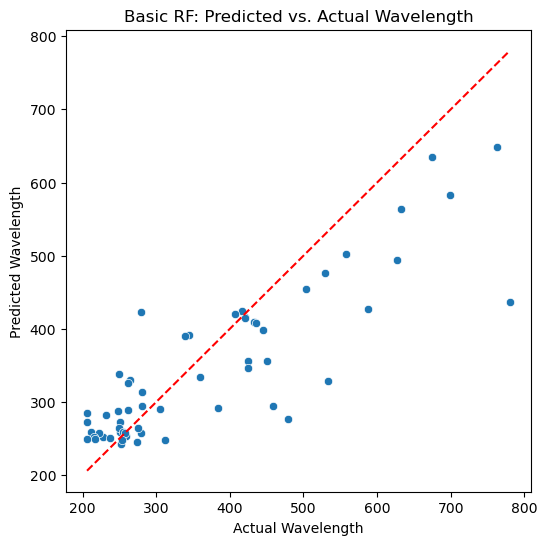

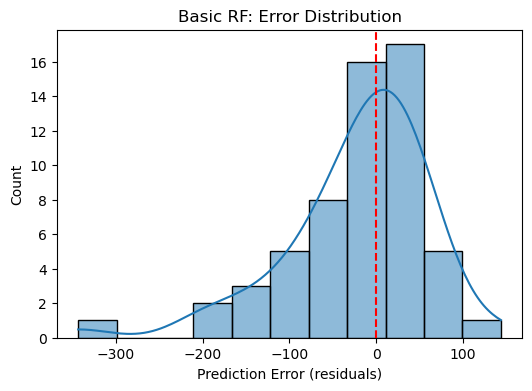

In [7]:
# =========================
# 7. Plot Results
# =========================

# 1. Predicted vs. Actual Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_optimized)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
)
plt.xlabel("Actual Wavelength")
plt.ylabel("Predicted Wavelength")
plt.title("Basic RF: Predicted vs. Actual Wavelength")
plt.show()

# 2. Error Distribution
errors = y_pred_optimized - y_test  # residuals
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Prediction Error (residuals)")
plt.ylabel("Count")
plt.title("Basic RF: Error Distribution")
plt.show()